In [3]:
%autoreload 2

In [18]:
from collections import defaultdict
import copy
import os
import sys

from IPython.display import display, Markdown, HTML
from Levenshtein import distance as _edit_distance
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sys.path.append(os.path.abspath('..'))

import llm_feedback.pilot.tasks as tasks
from llm_feedback.pilot.tasks import mbpp
from llm_feedback.utils.io import read_json


In [5]:
MBPP_OUTPUT_PATH = '../outputs/gpt-3.5-turbo-0613__gpt-3.5-turbo-0613__gpt-3.5-turbo-0613__mbpp-test-gen__train__metrics.jsonl'

mbpp_outputs = read_json(MBPP_OUTPUT_PATH)

In [6]:
# TEST_ID_KEYS = ['0', '1', '2']
GOLD_TEST_KEYS = ('test_list_0', 'test_list_1', 'test_list_2')
INITIAL_SOLUTION = 'initial_solution'
GOLD_CODE = 'gold_code'
COMPLETION_ID_KEY = 'completion_id'
RESULT_FIELD = 'result'
PASSED_FIELD = 'passed'
GOLD_TEST = 'gold_test'
MODEL_TEST = 'model_test'

accuracy_by_problem = {INITIAL_SOLUTION: {GOLD_TEST: [], MODEL_TEST: []}, GOLD_CODE: {GOLD_TEST: [], MODEL_TEST: []}}
all_problem_result_summaries = []
num_model_tests_by_problem = []

missing_names = defaultdict(set)
exception_types = defaultdict(set)

for problem_id, problem_results in enumerate(mbpp_outputs):
    problem_results_summary = {INITIAL_SOLUTION: {GOLD_TEST: [], MODEL_TEST: []}, GOLD_CODE: {GOLD_TEST: [], MODEL_TEST: []}}
    test_id_keys = [key for key in problem_results.keys() if key.isdigit()]
    for test_id in sorted(test_id_keys):
        test_results = problem_results[test_id]
        for i, code_test_results in test_results:
            code_type = INITIAL_SOLUTION if code_test_results[COMPLETION_ID_KEY] == 0 else GOLD_CODE
            test_type = GOLD_TEST if int(test_id) < 3 else MODEL_TEST
            code_test_result = code_test_results[RESULT_FIELD]
            if code_test_result is None:
                print(f'Problem {problem_id}, test {test_id} has result None')
            if 'is not defined' in code_test_result.lower():
                # print(f'Problem {problem_id}, test {test_id} has defintion issues: {code_test_result}')
                name_index = code_test_result.find('name')
                if name_index != -1:
                    space_index = code_test_result.find(' ', name_index)
                    next_space_index = code_test_result.find(' ', space_index + 1)
                    missing_name = code_test_result[space_index + 1:next_space_index]
                    missing_names[missing_name.replace("'", '')].add(problem_id)
            if '<class' in code_test_result:
                exception_class_index = code_test_result.find('<class')
                exception_start = code_test_result.find("'", exception_class_index)
                exception_end = code_test_result.find("'", exception_start + 1)
                exception_type = code_test_result[exception_start + 1:exception_end]
                exception_types[exception_type].add(problem_id)
            code_test_passed = code_test_results[PASSED_FIELD]
            if code_test_passed is None:
                print(f'Problem {problem_id}, test {test_id} has passed None')
                code_test_passed = False
            problem_results_summary[code_type][test_type].append(code_test_passed)

    all_problem_result_summaries.append(problem_results_summary)
    for model_type in [INITIAL_SOLUTION, GOLD_CODE]:
        for test_type in [GOLD_TEST, MODEL_TEST]:
            model_problem_results = problem_results_summary[model_type][test_type]
            if model_type == INITIAL_SOLUTION and test_type == GOLD_TEST:
                model_problem_results = model_problem_results[1:]
            accuracy_by_problem[model_type][test_type].append(np.mean(model_problem_results))
            

for model_key, key_results in accuracy_by_problem.items():
    for test_key, test_key_results in key_results.items():
        print(f'{model_key} {test_key} accuracy: {np.mean(test_key_results)}')


num_model_tests_by_problem = [len(t[INITIAL_SOLUTION][MODEL_TEST]) for t in all_problem_result_summaries]
print(np.mean(num_model_tests_by_problem), np.std(num_model_tests_by_problem), np.min(num_model_tests_by_problem), np.max(num_model_tests_by_problem))

print('Problems with fewest model tests:')
for problem_id in np.argsort(num_model_tests_by_problem)[:10]:
    print(f'Problem {problem_id}: {num_model_tests_by_problem[problem_id]}')

initial_solution gold_test accuracy: 0.795
initial_solution model_test accuracy: 0.7192043650793651
gold_code gold_test accuracy: 1.0
gold_code model_test accuracy: 0.6858293650793651
3.89 2.1349238862310758 3 16
Problems with fewest model tests:
Problem 0: 3
Problem 65: 3
Problem 64: 3
Problem 62: 3
Problem 61: 3
Problem 60: 3
Problem 59: 3
Problem 58: 3
Problem 66: 3
Problem 57: 3


### Matched-pairs t-tests

In [26]:
for test_type in GOLD_TEST, MODEL_TEST:
    model_solution_test_results = [rs[INITIAL_SOLUTION][test_type] for rs in all_problem_result_summaries]
    gold_code_test_results = [rs[GOLD_CODE][test_type] for rs in all_problem_result_summaries]

    model_solution_test_results = np.array([t for tl in model_solution_test_results for t in tl], dtype=float)
    gold_code_test_results = np.array([t for tl in gold_code_test_results for t in tl], dtype=float)

    result = stats.ttest_rel(model_solution_test_results, gold_code_test_results)
    print(f'For {test_type} tests, model solution vs. gold code: {result.statistic:.3f}, {result.pvalue:.3f}')


result_summary = (model_solution_test_results * 2) + gold_code_test_results
print(np.unique(result_summary, return_counts=True))

For gold_test tests, model solution vs. gold code: -8.556, 0.000
For model_test tests, model solution vs. gold code: 0.911, 0.363
(array([0., 1., 2., 3.]), array([ 85,  26,  33, 245]))


In [7]:
edit_distances = []

for i, output in enumerate(mbpp_outputs):
    model_tests = set(output['model_test_cases'])
    gold_tests = set(output['test_cases'])
    intersection = model_tests.intersection(gold_tests)
    if intersection:
        print(f'Found overlapping tests in #{i}: {intersection}')

    output_edit_distances = [
        _edit_distance(model_test, gold_test)
        for model_test in model_tests
        for gold_test in gold_tests
    ]
    edit_distances.append(output_edit_distances)


min_edit_distances = [min(dists) for dists in edit_distances]
mean_edit_distances = [np.mean(dists) for dists in edit_distances]

print(f'Mean-min edit distance: {np.mean(min_edit_distances)}')
print(f'Mean-mean edit distance: {np.mean(mean_edit_distances)}')

sorted_indices = np.argsort(min_edit_distances)
for i in range(10):
    idx = sorted_indices[i]
    print(f'#{i} ({idx}) min edit distance: {min_edit_distances[idx]}')

Mean-min edit distance: 38.4
Mean-mean edit distance: 62.542889550264555
#0 (68) min edit distance: 1
#1 (83) min edit distance: 1
#2 (56) min edit distance: 1
#3 (82) min edit distance: 1
#4 (87) min edit distance: 2
#5 (7) min edit distance: 2
#6 (35) min edit distance: 3
#7 (72) min edit distance: 3
#8 (33) min edit distance: 3
#9 (4) min edit distance: 3


In [8]:
def visualize_outputs(index):
    output = mbpp_outputs[index]
    display(Markdown(f'Problem text: {output["text"]}'))
    
    code_block_lines = [
        '```python', 
        '# Gold code:', 
        output['gold_code'], 
        '',
        '# Model code:',
        output['initial_solution'],
        '',
    ]

    for i, test in enumerate(output['test_cases']): 
        code_block_lines.append(f'# Gold Test #{i} (Gold passed = {all_problem_result_summaries[index][GOLD_CODE][GOLD_TEST][i]}, Model passed = {all_problem_result_summaries[index][INITIAL_SOLUTION][GOLD_TEST][i]}):')
        code_block_lines.append(test)

    code_block_lines.append('')

    for i, test in enumerate(output['model_test_cases']):
        code_block_lines.append(f'# Model Test #{i} (Gold passed = {all_problem_result_summaries[index][GOLD_CODE][MODEL_TEST][i]}, Model passed = {all_problem_result_summaries[index][INITIAL_SOLUTION][MODEL_TEST][i]}):')
        code_block_lines.append(test)

    code_block_lines.append('```')
    display(Markdown('\n'.join(code_block_lines)))

1 0.5 0.5
2 0.0 0.4
8 0.5 0.6666666666666666
11 0.0 0.6666666666666666
14 0.0 0.0
16 0.0 0.0
19 0.5 0.0
25 0.0 0.0
37 0.0 0.0
39 0.0 0.0
41 0.0 1.0
42 0.5 0.3333333333333333
46 0.0 0.6666666666666666
51 0.0 0.6666666666666666
59 0.0 1.0
60 0.0 0.3333333333333333
62 0.5 0.0
67 0.0 0.3333333333333333
68 0.5 0.9375
69 0.0 0.6666666666666666
70 0.5 0.5
83 0.0 0.6666666666666666
93 0.0 1.0
98 0.0 0.75


Text(0.5, 1.0, '(Gold Code | Model Tests) Accuracy where (Model Code | Gold Tests) Accuracy < 1.0')

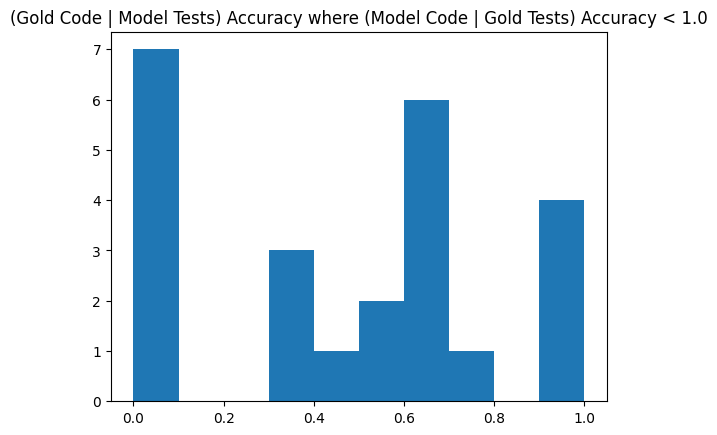

In [9]:
gold_code_model_test_accuracies = []


for i, acc in enumerate(accuracy_by_problem[INITIAL_SOLUTION][GOLD_TEST]):
    if acc != 1.0:
        gold_code_model_test_acc = accuracy_by_problem[GOLD_CODE][MODEL_TEST][i]
        print(i, acc,gold_code_model_test_acc )
        gold_code_model_test_accuracies.append(gold_code_model_test_acc)

plt.hist(gold_code_model_test_accuracies, bins=10)
plt.title('(Gold Code | Model Tests) Accuracy where (Model Code | Gold Tests) Accuracy < 1.0')
# accuracy_by_problem

In [10]:
visualize_outputs(14)


Problem text: Write a function to find average value of the numbers in a given tuple of tuples.

```python
# Gold code:
def average_tuple(nums):
    result = [sum(x) / len(x) for x in zip(*nums)]
    return result

# Model code:
def average_tuple(t):
    return [sum(subtuple)/len(subtuple) for subtuple in t]

# Gold Test #0 (Gold passed = True, Model passed = False):
assert average_tuple(((10, 10, 10, 12), (30, 45, 56, 45), (81, 80, 39, 32), (1, 2, 3, 4)))==[30.5, 34.25, 27.0, 23.25]
# Gold Test #1 (Gold passed = True, Model passed = False):
assert average_tuple(((1, 1, -5), (30, -15, 56), (81, -60, -39), (-10, 2, 3)))== [25.5, -18.0, 3.75]
# Gold Test #2 (Gold passed = True, Model passed = False):
assert average_tuple( ((100, 100, 100, 120), (300, 450, 560, 450), (810, 800, 390, 320), (10, 20, 30, 40)))==[305.0, 342.5, 270.0, 232.5]

# Model Test #0 (Gold passed = False, Model passed = False):
assert average_tuple(((0,), (0, 0, 0, 0), (0, 0, 0, 0, 0))) == [0.0, 0.0, 0.0, 0.0, 0.0]
# Model Test #1 (Gold passed = False, Model passed = True):
assert average_tuple(((1, 2, 3), (4, 5, 6), (7, 8, 9))) == [2.0, 5.0, 8.0]
# Model Test #2 (Gold passed = False, Model passed = False):
assert average_tuple(((10, 20, 30, 40), (50, 60, 70, 80), (90, 100, 110, 120))) == [25.0, 55.0, 95.0, 115.0]
```

In [25]:
len(model_solution_test_results)

389

In [11]:
for i, acc in enumerate(accuracy_by_problem[INITIAL_SOLUTION][MODEL_TEST]):
    gold_code_model_test_acc = accuracy_by_problem[GOLD_CODE][MODEL_TEST][i]
    if acc > gold_code_model_test_acc:
        print(i, acc, gold_code_model_test_acc)


0 0.3333333333333333 0.0
1 1.0 0.5
4 1.0 0.0
14 0.3333333333333333 0.0
16 1.0 0.0
25 0.3333333333333333 0.0
27 1.0 0.6666666666666666
37 0.3333333333333333 0.0
39 1.0 0.0
42 1.0 0.3333333333333333
43 0.6666666666666666 0.3333333333333333
47 1.0 0.6666666666666666
48 1.0 0.6666666666666666
62 0.3333333333333333 0.0
69 1.0 0.6666666666666666
79 1.0 0.6666666666666666
82 1.0 0.3333333333333333


In [ ]:
visualize_outputs(48)


In [ ]:
accuracy_by_solution_type = {k: np.mean(v) for k, v in accuracy_by_problem.items()}
accuracy_by_solution_type

In [ ]:
full_accuracy_rate_by_solution_type = {k: np.mean(np.array(v) == 1.0) for k, v in accuracy_by_problem.items()}
full_accuracy_rate_by_solution_type

In [ ]:
feedback_acuracy_change_by_problem = np.array([accuracy_by_problem[REFINEMENT][i] - accuracy_by_problem[INITIAL_SOLUTION][i] for i in range(len(accuracy_by_problem[REFINEMENT]))])
feedback_change_indices = np.where(feedback_acuracy_change_by_problem != 0)[0]
feedback_acuracy_change_by_problem[feedback_change_indices], feedback_change_indices, len(feedback_change_indices)

In [ ]:
for i, delta in enumerate(feedback_acuracy_change_by_problem):
    if delta < 0:
        print(i, mbpp_outputs[i]['feedback'])

In [ ]:
# SyntaxError, ZeroDivisionError, TypeError, NotImplementedError
# Indices to re-check: 34, 52, 57, 85
exception_types['SyntaxError']

In [ ]:
i =57
print(mbpp_outputs[i]['text'])
print(mbpp_outputs[i]['initial_solution'])
print(mbpp_outputs[i]['feedback'])
print(mbpp_outputs[i]['refinement'])

for test_id in TEST_ID_KEYS:
    print(mbpp_outputs[i][f'test_list_{test_id}'])
    results = [test_results[1]['result'] for test_results in mbpp_outputs[i][test_id]]
    print(results)


In [ ]:
import heapq

def heap_sort(lst):
    heap = []
    for value in lst:
        heapq.heappush(heap, value)
    
    ordered = []
    while heap:
        ordered.append(heapq.heappop(heap))
    
    return ordered

assert heap_sort([1, 3, 5, 7, 9, 2, 4, 6, 8, 0])==[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
assert heap_sort([25, 35, 22, 85, 14, 65, 75, 25, 58])==[14, 22, 25, 25, 35, 58, 65, 75, 85]
assert heap_sort( [7, 1, 9, 5])==[1,5,7,9]


In [ ]:
mbpp_outputs[i]['0']

In [ ]:
plt.hist(feedback_acuracy_change_by_problem, bins=20)
plt.show()
plt.hist(feedback_acuracy_change_by_problem[feedback_change_indices])
plt.title('Change in test pass rate after feedback')
plt.ylabel('Count')
plt.xlabel('Change in test pass rate')
plt.show()

In [ ]:
from evaluate import load
import re
code_eval = load("guydav/restrictedpython_code_eval")
markdown_pattern = re.compile(r"```\w*")

import os
os.environ["HF_ALLOW_CODE_EVAL"] = '1'

ALLOWED_IMPORTS = ['typing', 'collections', 'math', 're', 'heapq', 'itertools', 'sys']
DEFAULT_ADDITIONAL_GLOBALS = {
    'all': all,
    'dict': dict,
    'filter': filter,
    'map': map,
    'max': max,
    'min': min,
    'sum': sum,
    'enumerate': enumerate,
    'reversed': reversed,
    'iter': iter,
}

In [ ]:


# output = mbpp_outputs[95]
output = copy.deepcopy(mbpp_outputs[52])

model_test_cases = mbpp._parse_test_cases(output['feedback'])
test_cases = [output[key] for key in ('test_list_0', 'test_list_1', 'test_list_2')] + model_test_cases
solutions = [output['initial_solution'], output['gold_code']]
solutions = [markdown_pattern.sub('', solution).strip() for solution in solutions]
solutions = [solution.replace('(object)', '') for solution in solutions]
if output['test_setup_code']:
    solutions = ['\n'.join([output['test_setup_code'], solution]) for solution in solutions]

r = code_eval.compute(
    references=test_cases, 
    predictions=[solutions] * len(test_cases), 
    k=[len(solutions)],
    allowed_imports=ALLOWED_IMPORTS,
    additional_globals=DEFAULT_ADDITIONAL_GLOBALS,
    timeout=60,
    allow_str_format=True,
    allow_underscore_variable_names=True,
    )[1]  # type: ignore

r